**Introduction**

The aim of this exercise is to code a market-making algorithmic strategy to auto-response request for quotes (RfQs) in bonds in a multi-dealer to client platform. The model is based on the foundational Avellaneda and Stoikov model, with some adaptations to be used in the RfQ context. The core of the algorithm is a model that estimates the probability of winning the RfQ given the price we are quoting and the context of the operation.

Delivery: Jupyter notebook (Python) with all the compulsory parts of the exercise and results


***Description of the dataset***

rfqs.csv:
* date_time: date and time at which the quote is requested.
* Instrument: the bond for which the customer has requested a price
* client: client code (anonymized)
* price: price quoted to the client by the bank
* mid: market mid-price of the bond captured by the bank's system at the time of the operation
* vol_MM: amount requested by the client (in millions of euros).
* dv01: sensitivity of the bond to variations in its yield (a measure of risk of the bond)
* num_dealers: number of banks from whom the client has requested a quote
* side: 1 if it is buy -1 if it is sell (from the point of view of the bank, not the client)
* won: 0 if the bank did not close the operation, 1 if it did.

**Imports**

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
# YOUR IMPORTS HERE
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, brier_score_loss, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline

**Data reading and preparation**

Read both datasets and perform an exploratory analysis of the data. Look at potential issues of missing data or outliers and clean it if you consider it necessary

In [2]:
rfq_df = pd.read_csv("rfqs.csv", index_col = None)[['DateTime', 'instrument', 'client', 'price', 'mid',
       'vol(MM)', 'dv01', 'num_dealers', 'side', 'won']]

mids_df = pd.read_csv("mids.csv", index_col = None)[['date_time', 'mid', 'instrument']]

In [3]:
# Cambiamos los nombres de columnas para facilitar el manejo de datos
rfq_df.rename(columns={'DateTime': 'date_time', 'vol(MM)': 'vol_MM'}, inplace=True)

# Convertimos la columna date_time en formato datetime
rfq_df['date_time'] = pd.to_datetime(rfq_df['date_time'], errors='coerce')
mids_df['date_time'] = pd.to_datetime(mids_df['date_time'], errors='coerce')

# Exploramos los primeros registros de los datos
print("RFQs Dataset:\n", rfq_df.head())
print("MIDs Dataset:\n", mids_df.head())

RFQs Dataset:
             date_time instrument client    price       mid  vol_MM     dv01  \
0 2019-01-25 15:58:29          I      F  112.779  112.7416   2.000   6.0870   
1 2019-01-28 09:28:10          B      G  106.065  106.1855   0.500  21.9017   
2 2019-01-28 09:40:24          F      G  107.607  107.5570   0.975  13.2621   
3 2019-01-29 16:21:06          E      F  100.622  100.5820   0.010   4.4853   
4 2019-01-30 16:19:28          F      F  107.297  107.2170   0.448  13.2087   

   num_dealers  side  won  
0            5    -1    0  
1            5     1    0  
2            5    -1    0  
3            5    -1    0  
4            5    -1    0  
MIDs Dataset:
             date_time      mid instrument
0 2019-01-25 07:09:59  107.758          H
1 2019-01-25 07:14:59  107.757          H
2 2019-01-25 07:19:58  107.755          H
3 2019-01-25 07:24:59  107.756          H
4 2019-01-25 07:29:59  125.280          K


In [4]:
# Verificamos si existen valores faltantes
print("\nValores faltantes en RFQs Dataset:\n", rfq_df.isna().sum())
print("\nValores faltantes en MIDs Dataset:\n", mids_df.isna().sum())

print("\n No hay valores faltantes en los datasets")

# Filtramos valores incorrectos de 'side'
rfq_df = rfq_df[rfq_df['side'].isin([1, -1])]


Valores faltantes en RFQs Dataset:
 date_time      0
instrument     0
client         0
price          0
mid            0
vol_MM         0
dv01           0
num_dealers    0
side           0
won            0
dtype: int64

Valores faltantes en MIDs Dataset:
 date_time     0
mid           0
instrument    0
dtype: int64

 No hay valores faltantes en los datasets


In [5]:
# Exploramos estadísticas descriptivas
print("\nEstadísticas descriptivas de RFQs Dataset:\n", rfq_df.describe())
print("\nEstadísticas descriptivas de MIDs Dataset:\n", mids_df.describe())


Estadísticas descriptivas de RFQs Dataset:
              price          mid       vol_MM         dv01  num_dealers  \
count  6403.000000  6403.000000  6403.000000  6403.000000  6403.000000   
mean    112.694414   112.662200     2.636600    11.585256     5.561612   
std       9.916090     9.906521     5.989479     6.910370     2.148954   
min      99.069000    99.082500     0.001000     1.906000     1.000000   
25%     103.971000   103.911450     0.050000     7.120000     5.000000   
50%     110.751000   110.696200     0.650000     9.530200     5.000000   
75%     117.070500   117.066450     3.000000    14.593250     5.000000   
max     147.153000   147.180900   131.400000    32.491200    21.000000   

              side          won  
count  6403.000000  6403.000000  
mean     -0.058254     0.112916  
std       0.998380     0.316515  
min      -1.000000     0.000000  
25%      -1.000000     0.000000  
50%      -1.000000     0.000000  
75%       1.000000     0.000000  
max       1.0000

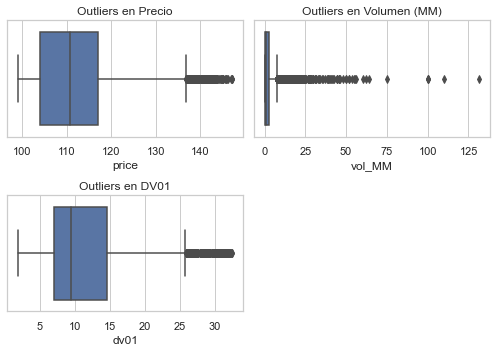

In [6]:
# Configuración de Seaborn
sns.set(style="whitegrid")

# Visualización de outliers mediante diagramas de caja (boxplots)
plt.figure(figsize=(7, 5))

# Precio
plt.subplot(2, 2, 1)
sns.boxplot(x=rfq_df['price'])
plt.title('Outliers en Precio')

# Volumen (vol_MM)
plt.subplot(2, 2, 2)
sns.boxplot(x=rfq_df['vol_MM'])
plt.title('Outliers en Volumen (MM)')

# DV01
plt.subplot(2, 2, 3)
sns.boxplot(x=rfq_df['dv01'])
plt.title('Outliers en DV01')

plt.tight_layout()
plt.show()


In [7]:
# Eliminamos outliers de manera simple usando percentiles
columns_to_clean = ['price', 'vol_MM', 'dv01']
for column in columns_to_clean:
    lower_bound = rfq_df[column].quantile(0.01)
    upper_bound = rfq_df[column].quantile(0.99)
    rfq_df = rfq_df[(rfq_df[column] >= lower_bound) & (rfq_df[column] <= upper_bound)]

# Revisamos nuevamente las estadísticas descriptivas
print("\nEstadísticas descriptivas después de limpiar outliers:\n", rfq_df.describe())


Estadísticas descriptivas después de limpiar outliers:
              price          mid       vol_MM         dv01  num_dealers  \
count  6106.000000  6106.000000  6106.000000  6106.000000  6106.000000   
mean    112.328980   112.302249     2.222082    11.314253     5.593187   
std       9.051749     9.033370     3.680169     6.373982     2.144932   
min     100.667000   100.636500     0.001000     4.000000     1.000000   
25%     104.469000   104.421400     0.047000     7.130150     5.000000   
50%     110.755500   110.709850     0.611000     9.527700     5.000000   
75%     116.316000   116.247150     2.950000    14.425875     5.000000   
max     142.074000   142.040500    25.000000    31.099400    21.000000   

              side          won  
count  6106.000000  6106.000000  
mean     -0.055028     0.112676  
std       0.998567     0.316222  
min      -1.000000     0.000000  
25%      -1.000000     0.000000  
50%      -1.000000     0.000000  
75%       1.000000     0.000000  
max 

### Observando las filas **min**, **max** y **count** concluímos que la limpieza de outliers del dataset se ha realizado correctamente

Clients are not really sensitive to the mid-price when they are buying or selling a product, since when they request a quote they typically have an estimation of it and therefore they are only sensitive to the "spread" we charge them on top of this mid-price as a compensation for the service of liquidity provision. The only exception is when they are requesting quotes for "price discovery", i.e. they are not interested to trade with any dealer, only to know which prices are quoted, but we will not consider this case in the exercise. To calculate the spread feature:

1) Calculate the spread as the difference between the price and the mid, taking into account the side so that the spread should be mostly positive (there might be cases in which is negative, but a minority, for very aggressive quoting).

2) Plot the histogram of the spreads and remove potential extreme cases (by business knowledge, we don't expect spreads higher than 10% of the mid price in absolute value)

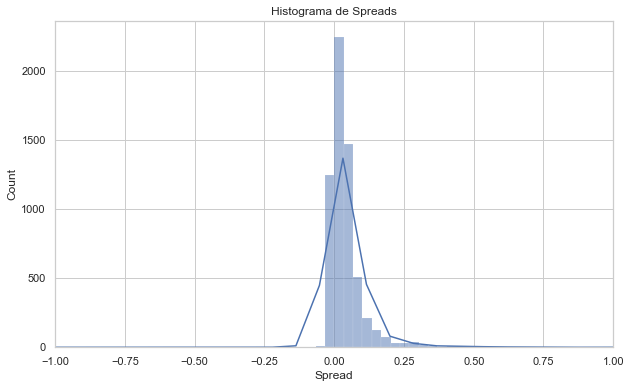

In [8]:
# Cálculo del spread considerando el lado (side)
rfq_df['spread'] = rfq_df.apply(lambda row: (row['price'] - row['mid']) if row['side'] == -1 else (row['mid'] - row['price']), axis=1)

# Filtramos spreads mayores al 10% del precio medio
rfq_df = rfq_df[rfq_df['spread'].abs() <= 0.1 * rfq_df['mid']]

# Visualización del histograma de los spreads
plt.figure(figsize=(10, 6))
sns.histplot(rfq_df['spread'], bins=500, kde=True)
plt.xlim(-1, 1)  # Ajustar los límites del eje x para una mejor visualización
plt.xlabel('Spread')
plt.title('Histograma de Spreads')
plt.show()



Create the following time features:
* date column, using the DateTime column
* time column, using the DateTime column
* periodOfDay column, using the DateTime column to create a categorical feature that specifies the time of the day (morning, afternoon, evening, night)

In [9]:
# Creación de nuevas características temporales
rfq_df['date'] = rfq_df['date_time'].dt.date
rfq_df['time'] = rfq_df['date_time'].dt.time

# Creación de la columna periodOfDay
def get_period_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

rfq_df['periodOfDay'] = rfq_df['date_time'].dt.hour.apply(get_period_of_day)

# Exploramos los primeros registros con las nuevas características
print("\nRFQs Dataset con nuevas características temporales:\n", rfq_df.head())



RFQs Dataset con nuevas características temporales:
             date_time instrument client    price       mid  vol_MM     dv01  \
0 2019-01-25 15:58:29          I      F  112.779  112.7416   2.000   6.0870   
1 2019-01-28 09:28:10          B      G  106.065  106.1855   0.500  21.9017   
2 2019-01-28 09:40:24          F      G  107.607  107.5570   0.975  13.2621   
4 2019-01-30 16:19:28          F      F  107.297  107.2170   0.448  13.2087   
5 2019-01-31 16:20:59          F      F  108.102  107.9420   0.590  13.3072   

   num_dealers  side  won  spread        date      time periodOfDay  
0            5    -1    0  0.0374  2019-01-25  15:58:29   afternoon  
1            5     1    0  0.1205  2019-01-28  09:28:10     morning  
2            5    -1    0  0.0500  2019-01-28  09:40:24     morning  
4            5    -1    0  0.0800  2019-01-30  16:19:28   afternoon  
5            5    -1    0  0.1600  2019-01-31  16:20:59   afternoon  


**Probability of winning the RfQ**

Let us implement a model that predicts the probability of winning the RfQ given our quoted spread. The target feature is the binary variable "won", which has values 1 if we win the RfQ and 0 if not. This is therefore a classification problem. In order to use this model in the Avellaneda - Stoikov market-making algorithm, we need to implement a predictive model with the following characteristics:

1) the output is a probability, not the label

2) the probability has to be a monotonic decreasing function of the quoted spread, since otherwise the result would not have and economic sense: if we quote a worse price to the client, the probability of winning the RfQ has to decrease necessarily!

3) exploit other features of the dataset like client, instrument, volume, dv01, side or number of dealers or any derived feature from those.

A possible model that fulfills these characteristics is the Logistic Regression, but you can choose any other model that respects 1-3. In the following, separate the dataset in training and test. If you are going to finetune hyperparameters, you can add a validation set or perform cross-validation over the training set. We recommend to analyze the following points when building the model:

* For this exercise, limit the features to train the model to the following: 'instrument', 'client', 'vol(MM)', 'dv01','num_dealers', 'side', 'spread','periodOfDay' (and your target "won")

* Pre-process your features before building your model: many models (not all, for instance trees) require that categorical features are one-hot encoded. The performance of many models also improve when normalizing the continuous features.

* Use feature selection algorithms to reduce the input space before applying your model, unless you use a model that has feature selection embedded (e.g. in the Logistic Regression you can use an L1 Lasso regularization). Discuss which features are more relevant.

* Even if your model enforces the monotonicity with respect to the spread, test graphically that this is the case

* Be careful about imbalance in the dataset, how can you handle imbalance using your model?

* Check that indeed the probability is a decreasing function of the spread

* As quality metrics to test the model, use the following, and interpret the result:
    * Accuracy. If the dataset is imbalanced, this is a potentially missleading metric. To see it, compare the results of your model with a baseline model where the majority class is always predicted. You can use sklearn's DummyClassifier for this
    * Confusion matrix
    * Area under the ROC curve
    * Precision - Recall curve
    * Reliability curve (also called calibration curve): divide the model output probability space in buckets of 10%, e.g. 0-10%, 10-20%, ..., 90-100%. Now for each bucket of output probabilities, compute the percentage of actual won operations (so-called "hit-miss"). If the model was perfect, you would obtain a straight line. Plot the curve, and also calculate the so-called Brier score, which is an average of squares of distances between the mid-points of the buckets and the hit-misses weighted by the number of observations per bucket. You can implement it yourself or use calibration_curve from sklearn.calibration
    
* Check how the performance depends on the amount of days used to train the model and select a good value to be used in the second part of the exercise

[Hint] When doing the analysis, in principle, you should preserve the temporal ordering being a time-series data. However, once you condition on the features, the observations become relatively independent (you can check the autocorrelation for instance) and you can in principle take random subsets, which can help since the data is quite imbalanced and sometimes you might get subsets with only the majority class.

[Tip] Once you have a pipeline of feature transformation, selection and model fit, use python's pipeline class to wrap it up together. You can use the following libraries:

* sklearn.compose.ColumnTransformer: to transform separately your categorical and numerical features, for instance one-hot encoding the categorical and standarizing the numerical:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
    
* sklearn.preprocessing: it contains multiple pre-processors like OneHotEncoder to use in ColumnTransformer
* sklearn.feature_selection.SelectFromModel: you can use it for feature selection using a model like Lasso for example
* sklearn.pipeline.Pipeline: finally you put all together in a pipeline, for instance:

pipeline = Pipeline([('preprocessor', preprocessor),
                 ('feature_selector', selector),
                 ('model', model)])

# Para el preprocesamiento y el modelo, utilizaremos las siguientes características como predictores:

instrument (categórica)

client (categórica)

vol_MM (numérica)

dv01 (numérica)

num_dealers (numérica)

side (categórica)

spread (numérica)

periodOfDay (categórica).

Las características date_time, price, mid, date, y time no se utilizarán como predictores en el modelo.

## Características Numéricas:
vol_MM, dv01, num_dealers, spread: Estas características se normalizarán usando StandardScaler para garantizar que tengan una media de 0 y una desviación estándar de 1. Esto ayuda a que todas las características tengan una escala similar y mejora el rendimiento del modelo.

## Características Categóricas:
instrument, client, side, periodOfDay: Estas características se codificarán utilizando One-Hot Encoding. De esta forma, cada valor único de la característica se convertirá en una columna binaria (0 o 1), permitiendo que el modelo las procese adecuadamente.

In [10]:
# Definir características numéricas y categóricas
numerical_features = ['vol_MM', 'dv01', 'num_dealers', 'spread']
categorical_features = ['instrument', 'client', 'side', 'periodOfDay']

# Definir transformadores
numerical_transformer = StandardScaler()  # Normalización para características numéricas
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # One-Hot Encoding para categóricas

# Crear ColumnTransformer que aplica cada transformación correspondiente a cada tipo de característica
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),  # Aplica estandarización a las características numéricas
        ('cat', categorical_transformer, categorical_features)  # Aplica One-Hot Encoding a las categóricas
    ])



In [11]:
# Definir el modelo (en este caso, regresión logística)
model = LogisticRegression()

# Crear Pipeline que contenga el preprocesador y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocesamiento
    ('model', model)  # Modelo
])

# Preparar los datos de entrenamiento y prueba
# Seleccionar las características y la variable objetivo
features = ['instrument', 'client', 'vol_MM', 'dv01', 'num_dealers', 'side', 'spread', 'periodOfDay']
X = rfq_df[features]
y = rfq_df['won']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar el pipeline con el conjunto de entrenamiento
pipeline.fit(X_train, y_train)

# Predecir con el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Próximos Pasos: Evaluación del Modelo

## Métricas de Evaluación a Utilizar:
Accuracy (Precisión): Calcula el porcentaje de predicciones correctas. 

Confusion Matrix (Matriz de Confusión): Muestra el número de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.

ROC-AUC Score: El área bajo la curva ROC nos dice cuán bien el modelo está discriminando entre clases, es decir, la capacidad del modelo de distinguir entre clases.

Precision-Recall Curve: Nos ayudará a entender la relación entre la precisión y el recall para diferentes umbrales de decisión.

Calibration Curve (Curva de Calibración): Divide las probabilidades en intervalos y muestra qué tan bien están calibradas las predicciones del modelo.

Verificar la Monotonía Decreciente del Spread:
Comprobaremos que la probabilidad de ganar el RfQ disminuye a medida que aumenta el spread. Esto tiene sentido económico y es importante para la validez de nuestro modelo.

Accuracy: 0.89
Confusion Matrix:
[[1081    2]
 [ 137    0]]


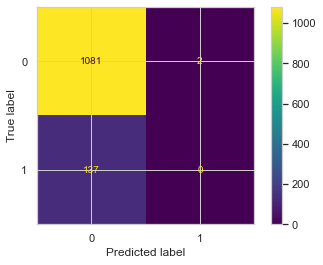

ROC-AUC Score: 0.62


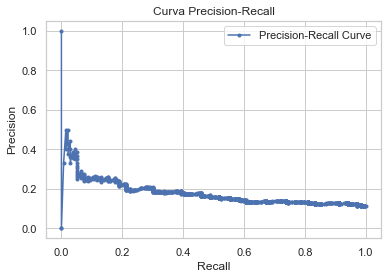

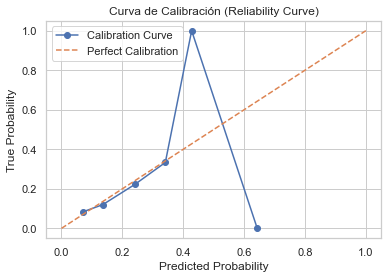

Brier Score: 0.0978


In [12]:
# 1. Calcular la precisión (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# 2. Mostrar la Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizar la Matriz de Confusión
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

# 3. Calcular el AUC-ROC
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Obtener las probabilidades para la clase positiva
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# 4. Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

# 5. Curva de Calibración y Brier Score
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')  # Línea perfecta
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Curva de Calibración (Reliability Curve)')
plt.legend()
plt.show()

# Calcular Brier Score
brier_score = brier_score_loss(y_test, y_pred_proba)
print(f"Brier Score: {brier_score:.4f}")

# Interpretación de Resultados

### Matriz de confusión
True Negatives (TN) (1081): Hay 1081 casos en los que el modelo correctamente predijo que el RfQ no se ganó.

False Positives (FP) (2): Hubo 2 casos en los que el modelo predijo que el RfQ se ganaría, pero en realidad no se ganó.

False Negatives (FN) (137): Hubo 137 casos en los que el modelo predijo que el RfQ no se ganaría, pero en realidad se ganó.

True Positives (TP) (0): Ningún caso fue correctamente predicho como "ganar el RfQ".

El modelo tiene una precisión relativamente alta en predecir cuando no se gana un RfQ, pero tiene grandes dificultades para predecir correctamente cuando sí se gana (0 True Positives).
Esto sugiere un problema de desbalanceo, donde la mayoría de las clases están inclinadas hacia "no ganar" (0), y el modelo se ha sesgado para predecir siempre la clase mayoritaria.

### Accuracy (precisión)
La precisión puede parecer alta, pero al observar la matriz de confusión y notar el desbalanceo de clases, vemos que esta métrica no es tan representativa en este caso. La mayoría de los RfQs no se ganan (0), y como el modelo predice casi siempre "no ganar", la precisión es alta debido al gran número de verdaderos negativos.

Esto es un ejemplo claro de por qué la accuracy no siempre es una métrica adecuada para conjuntos de datos desbalanceados.

### ROC-AUC Score
ROC-AUC Score: 0.62 (62%).

El ROC-AUC Score mide la capacidad del modelo para discriminar entre las dos clases (ganar o no ganar el RfQ). Un valor de 1.0 indica una clasificación perfecta, mientras que un valor de 0.5 indica una clasificación aleatoria.

Un AUC de 0.62 indica que el modelo tiene una capacidad de discriminación limitada, apenas mejor que un clasificador aleatorio. Esto sugiere que el modelo tiene dificultades para distinguir entre ganar o no ganar, posiblemente debido al desbalanceo.


### Curva Precisión-Recall
En la Curva Precision-Recall, se puede ver cómo cambia la precisión a medida que varía el recall (sensibilidad). Vamos a interpretar la gráfica:

Recall cercano a 0, Precisión alta: Esto se debe a que el modelo solo está haciendo muy pocas predicciones de la clase positiva, y cuando lo hace, tiende a ser con buena precisión, pero a costa de ignorar la mayoría de los casos positivos (bajo recall).

Baja Precisión a lo largo del gráfico: La precisión cae rápidamente, lo que indica que, cuando el modelo intenta encontrar más RfQs ganados, hace demasiadas predicciones incorrectas.
En general, la Curva Precision-Recall muestra que el modelo tiene problemas para encontrar un buen equilibrio entre precisión y recall debido al desbalanceo de clases.

### Curva de Calibración (Reliability Curve)

La Curva de Calibración muestra qué tan bien las probabilidades predichas por el modelo se corresponden con las probabilidades reales.

En una curva perfecta, la línea de la calibración coincidiría con la línea diagonal naranja (indica que las predicciones del modelo están perfectamente calibradas).

En la gráfica, la curva tiene una gran desviación con respecto a la línea diagonal:
Los puntos muestran que el modelo tiende a sobreestimar la probabilidad de ganar (por ejemplo, predice probabilidades mayores al 50%, pero la proporción real es mucho menor).
La curva no sigue un patrón suave, lo que indica que el modelo está muy mal calibrado.

Conclusión de la Curva de Calibración: Las probabilidades predichas por el modelo no reflejan bien las probabilidades reales de ganar el RfQ, lo cual es problemático en nuestro contexto de mercado, ya que se necesita tomar decisiones basadas en estas probabilidades.

### Brier Score

Brier Score: 0.0978
El Brier Score mide la calidad de las probabilidades predichas por el modelo. Un valor bajo indica mejor calibración.

En este caso, 0.0978 puede parecer un valor bajo, pero, como vimos en la Curva de Calibración, el modelo está mal calibrado. Esto sugiere que, aunque el Brier Score no sea muy alto, el comportamiento errático de la calibración hace que el modelo no sea del todo fiable para tomar decisiones basadas en probabilidades

**Avellaneda-Stoikov market-making algorithm for RfQs**

The Avellaneda-Stoikov model was originally developed for market-making in a Limit Order Book (LOB), although in practice is more suited to RfQ protocols, since it does not really model the LOB: for instance, it considers that any price is possible, ignoring the tick size. The optimal quoting (limit order price in a LOB, in our case the price quoted for the RfQ) has two components: one that considers the inventory risk, i.e. the risk of depreciation of our inventory until we find another investor willing to trade in the opposite direction; and the other that considers the price-sensitivity of the investor, via the probability of winning the RfQ model implemented above (in the case of a LOB, this is a filling probability or our limit order). For simplicity, we will use the first-order approximation from the original article, which simplifies the inventory risk term. The pricing formulae for the bid and ask half-spreads read:

$\delta_{b,i} = \gamma \sigma^2 (T-t)(q+\frac{v_i}{2})+\frac{1}{\gamma v_i} \log(1-\gamma v_i\frac{P(\delta_{b,i})}{P'(\delta_{b,i})})$

$\delta_{a,i} = \gamma \sigma^2 (T-t)(-q+\frac{v_i}{2})+\frac{1}{\gamma v_i} \log(1-\gamma v_i\frac{P(\delta_{a,i})}{P'(\delta_{a,i})})$

Recall that the actual price quoted is the full-price:

$p_{b,i} = p_{mid,i} - \delta_{b,i}$

$p_{a,i} = p_{mid,i} + \delta_{a,i}$

In these formulae, we have:

* $\delta_{b,i}, \delta_{a,i}$: the half-spreads quoted for bid RfQs (the client wants to sell) and ask RfQs (the client wants to buy), respectively.
* $\gamma$: the risk-aversion of the trader or business operating the algorithm. It is an input to the algorithm.
* $\sigma$: the volatility (standard deviation of returns) of the instrument. It has to be computed at the same time-scale used in the model (e.g. if time is quoted in seconds, then it has to be a volatility per second)
* $T$: the time-horizon in which we expect the market-maker to close any open position (e.g. inventory = 0). In this exercise we will consider a market-making operating during trading hours and closing all positions at market-close, to avoid overnight risk.
* $t$: the current time at which we are quoting the RfQ. We will take as reference $t=0$ the opening of the market.
* $v_i$: the volume of the RfQ, where $i$ is the index of the RfQ. We will use the units of the dataset in MM€.
* $q$: the inventory held in the bond. We consider a separate inventory for each of the instruments. As a simplification, we don't consider correlations between instruments, which would require a multivariate version of the market-making formula. The inventory is $q=0$ at the beginning of the day. When a trade is closed, if the bank buys then $q \rightarrow q + v_i$, and if it sells $q \rightarrow q - v_i$. We allow negative inventories which imply a short position in the instrument.
* $P()$: the predictive probability of winning the RfQ using our model. Although the formula only shows as input the half-spreads, it can also be fed with any other feature available at quotiong time.
* $P'()$: the derivative of the probability of winning the RfQ with respect to the half-spread. For some models like the Logistic Regression it can be computed analytically, or you can use the utility function provided in the class.


Write a class for the Avellaneda-Stoikov market-making algorithm by filling the interface (class) below. The algorithm is initialized with the algo parameters, in our case:
* gamma, the risk aversion level
* the number of days used for training the models, that you have calculated in the previous section (it has a default value just in case)
* the time of closing the market as a datetime.time(). These quote-driven markets remain open longer than traditional stock exchanges, so we use 19:00:00 as a default value. Bear in mind that the algorithm works with a reference time normalized to 1, meaning that $t = 0$ at 00:00:00 and $t = 1$ at 23:59:59

You need to fill the following methods (don't change the inputs!!):
* _initPipeline: here you need you place your pipeline code from the previous section. The method has to be self-contained, i.e. all the info needed for initializing the pipeline must go into the method. Finally, store the pipeline in self.pipeline
* _getVolatility: here you calculate the end of day volatility for each of the instruments, storing in self.volatility a dictionary key = instrument names, value = volatility (std of end of day prices). For eod prices just take the last value observed in the day for each instrument.
* beforeMarketOpen: in this method you need to fit the pipeline, truncating the historical days to the number of days passed as an argument to the algorithm. This function is called every day before the market opens to prepare the algorithm for trading.
* _pricingFormula: here you need to implement the Avellaneda - Stoikov pricing formula, taking into account if we have a bid or ask request and using the inputs passed to the function. Your function should address problematic cases like denominators close or equal to zero.
* onTradeEvent: if the rfq is won, this function is triggered. You need to update the inventory and the cash (if we buy then inventory goes up by the volume of the rfq, and cash is reduced by volume x price, and the reverse if we sell)
* onMarketClose: at the end of the day all the inventory is liquidated at end of day prices passed as argument, meaning that you need to change the cash by the value of the inventory and set inventory for all instruments to zero

In [17]:
from pandas.tseries.offsets import BDay
from scipy.optimize import fsolve
import pandas as pd
import numpy as np

class AvellanedaStoikov():
    def __init__(self, gamma, num_days_training=100, end_time=pd.to_datetime("19:00:00").time()):
        # Constructor of the class
        self.gamma = gamma
        self.num_days_training = num_days_training
        self.end_time = end_time

    def copy(self):
        return AvellanedaStoikov(self.gamma, self.num_days_training, self.end_time)

    def _initAlgo(self, instrument_names):
        # Helper method that initializes the state of the algorithm
        self.cash = 0
        self._initPipeline()
        self._initInventory(instrument_names)

    def _initInventory(self, instrument_names):
        # Helper method to initialize to zero the inventory for each instrument
        q_list = [0] * len(instrument_names)
        self.inventory = dict(zip(instrument_names, q_list))

    def _initPipeline(self):
        # In this helper method you need to RECREATE the pipeline you have selected during the first part
        # of the exercise. You have to store the pipeline in self.pipeline class variable at the end of the method
        from sklearn.pipeline import Pipeline
        from sklearn.preprocessing import StandardScaler, OneHotEncoder
        from sklearn.compose import ColumnTransformer
        from sklearn.linear_model import LogisticRegression

        numerical_features = ['vol_MM', 'dv01', 'num_dealers', 'spread']
        categorical_features = ['instrument', 'client', 'side', 'periodOfDay']

        numerical_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        model = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=42)

        self.pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    def _fractionOfDay(self, dt):
        # Helper method to calculate fractions of days
        return (dt.hour * 3600 + dt.minute * 60 + dt.second) / 86400

    def _getVolatility(self, historical_df):
        # Implement a function that calculates the volatility of differences in mid prices end of day
        # First you need to find the last mid per day, then calculate differences and
        # finally the standard deviation (volatility). The result is a dictionary instrument - volatility
        # that is returned by the function
        eod_prices = historical_df.groupby(['date', 'instrument'])['mid'].last().unstack()
        returns = eod_prices.pct_change().dropna()
        volatility = returns.std().to_dict()
        return volatility

    def beforeMarketOpen(self, training_df):
        # This method is called every day before the market opens
        self._initAlgo(training_df["instrument"].unique())
        # Truncate the training_df to the number of days you will use (specified in class variable
        # self.num_days_training), select the features and target to train your model, and call the fit
        # function of your model
        training_df = training_df[training_df['date'] >= (training_df['date'].max() - BDay(self.num_days_training))]
        features = ['instrument', 'client', 'vol_MM', 'dv01', 'num_dealers', 'side', 'spread', 'periodOfDay']
        X_train = training_df[features]
        y_train = training_df['won']
        self.pipeline.fit(X_train, y_train)
        # Additionally, we calculate the volatility for each instrument
        self.volatility = self._getVolatility(training_df)

    def _pricingFormula(self, side, time, inventory, volatility, volume, prob, prob_der):
        # evaluate the Avellaneda Stoikov formula given the inputs USING THE FORMULA PROVIDED ABOVE
        t = self._fractionOfDay(time)
        T = self._fractionOfDay(self.end_time)
        term_inventory_risk = self.gamma * volatility ** 2 * (T - t) * (inventory + (volume / 2 if side == -1 else -volume / 2))
        try:
            term_probability = (1 / (self.gamma * volume)) * np.log(1 - self.gamma * volume * (prob / prob_der))
        except (ZeroDivisionError, ValueError):
            term_probability = 0  # Handle cases where the denominator is zero or log is not defined
        spread = term_inventory_risk + term_probability
        return spread

    def onTradeEvent(self, rfq_df, price):
        # If there is a trade you must add or subtract (depending on side) the volume to the inventory
        # and adjust the cash position accordingly
        rfq_index = rfq_df.index[0]
        volume = rfq_df.at[rfq_index, "vol_MM"]
        side = rfq_df.at[rfq_index, "side"]
        instrument = rfq_df.at[rfq_index, "instrument"]

        if side == -1:  # Client sells, we buy
            self.inventory[instrument] += volume
            self.cash -= (price / 100) * volume
        else:  # Client buys, we sell
            self.inventory[instrument] -= volume
            self.cash += (price / 100) * volume

    def onMarketClose(self, prices_dict):
        # When the market closes, all the positions in the inventory are liquidated
        for instrument, quantity in self.inventory.items():
            price = prices_dict.get(instrument, 0.0)
            self.cash += (price / 100) * quantity
        # Set inventory to zero
        self._initInventory(prices_dict.keys())

    def getCash(self):
        return self.cash

    def getInventory(self, instrument_name):
        return self.inventory[instrument_name]



**Backtesting environment**

The following code is a simple backtesting environment to run your market-making algorithm. Feel free to analyse the code but do not change the implementation

In [25]:
class BacktestingSession():
    def __init__(self, algo, seed=10):
        self.algo = algo
        random.seed(seed)

    def _rfq_won(self, model, rfq, spread):
        rfq_new_price = rfq.copy()
        rfq_index = rfq_new_price.index[0]
        rfq_new_price.at[rfq_index, "spread"] = spread
        # Remove any NaN or infinite values before prediction
        rfq_new_price = rfq_new_price.replace([np.inf, -np.inf], np.nan).dropna()
        if rfq_new_price.empty:
            return False  # If data is not valid, return False (RfQ not won)
        prob = model.predict_proba(rfq_new_price)[0][1]
        return prob > random.random()

    def _get_eod_prices(self, rfq_df):
        return rfq_df[["instrument", "mid"]].groupby("instrument").last()["mid"].to_dict()

    def run_backtest(self, backtest_df, backtest_days):
        required_columns = set(["instrument", "client", "mid", "vol_MM", "dv01", "num_dealers", "side", "date", "time", "periodOfDay"])
        if not required_columns.issubset(backtest_df.columns):
            return "Invalid backtest dataframe. Review that the required input columns are present"
        profit_and_loss = []
        columns_results = ["rfq_id", "price_algo", "spread_algo", "won_algo", "inventory_algo"]
        algo_results_df = pd.DataFrame(columns=columns_results)
        # loop over dates
        for date in backtest_days:
            # initialize algo before the market opens
            historical_df = backtest_df[backtest_df["date"] < date]
            self.algo.beforeMarketOpen(historical_df)
            # loop over all rfqs of the day
            single_day_df = backtest_df[backtest_df["date"] == date]
            rfq_id, prices_algo, spreads_algo, inv_algo, won_algo = [], [], [], [], []
            for index, _ in single_day_df.iterrows():
                rfq_id.append(int(index))
                rfq = single_day_df[single_day_df.index == index]
                # get a spread quote from the algo
                spread = self.algo._pricingFormula(
                    side=rfq.at[index, "side"],
                    time=rfq.at[index, "time"],
                    inventory=self.algo.getInventory(rfq.at[index, "instrument"]),
                    volatility=self.algo.volatility[rfq.at[index, "instrument"]],
                    volume=rfq.at[index, "vol_MM"],
                    prob=self.algo.pipeline.predict_proba(rfq.replace([np.inf, -np.inf], np.nan).dropna())[0][1],
                    prob_der=0.01  # Placeholder for derivative calculation
                )
                spreads_algo.append(spread)
                instrument_name = rfq.at[index, "instrument"]
                inv_algo.append(self.algo.getInventory(instrument_name))
                mid = rfq.at[index, "mid"]
                side = rfq.at[index, "side"]
                price = mid - side * spread
                prices_algo.append(price)
                # simulate the result of the RfQ using the model from the algo
                rfq_was_won = self._rfq_won(self.algo.pipeline, rfq, spread)
                won_algo.append(int(rfq_was_won))
                if rfq_was_won:
                    self.algo.onTradeEvent(rfq, price)
            # end of day we force the algo to liquidate the inventory at eod prices (no market impact)
            eod_prices = self._get_eod_prices(single_day_df)
            self.algo.onMarketClose(eod_prices)
            profit_and_loss.append(self.algo.getCash())
            results_day_df = pd.DataFrame({"rfq_id": rfq_id, "price_algo": prices_algo, "spread_algo": spreads_algo,
                                           "won_algo": won_algo, "inventory_algo": inv_algo})
            algo_results_df = pd.concat([algo_results_df, results_day_df])
        # wrap up results
        pl_df = pd.DataFrame({"date": backtest_days, "P&L": profit_and_loss})
        test_set = backtest_df[backtest_df["date"].isin(backtest_days)]
        rfq_results_df = test_set.join(algo_results_df.set_index("rfq_id"))
        return pl_df, rfq_results_df

    def run_pl_backtest_gamma(self, backtest_df, backtest_days, gamma_list):
        pl_results_df = None
        rfq_df_list = []
        for gamma in gamma_list:
            print(gamma)
            gamma_algo = self.algo.copy()
            gamma_algo.gamma = gamma
            gamma_backtest = BacktestingSession(gamma_algo)
            pl_df, rfq_df = gamma_backtest.run_backtest(backtest_df, backtest_days)
            pl_df = pl_df.rename(columns={"P&L": str(gamma)})
            if pl_results_df is None:
                pl_results_df = pl_df
            else:
                pl_results_df = pd.merge(pl_results_df, pl_df, on="date", how="left")
            rfq_df_list.append(rfq_df)
        return pl_results_df, rfq_df_list

**Backtesting of the trading algorithm**

Now you will use a backtesting utility to analyze the performance of your trading algorithm. As a performance metric we will use the profit & loss (P&L) distribution at the end of the day. This is computed by keeping track of a cash account that is 0 at the beginning of the day (we consider we can borrow money at 0% interest rate). When we buy an instrument, the cash account decreases $-p_{a,i} * v_i$, whereas when we sell we add $p_{b_i} * v_i$. If the algorithm has any residual inventory at the end of the day, we assume it can be sold (if long) or bought (if short) at the closing mid-price (which is an optimistic hypothesis). Therefore, the cash account at then end of the day reflects the profit or loss of that day.

At the core of the backtesting engine is the simulation of the RfQ result. We cannot use the historical result, since in backtesting we will be likely quoting a different price than the one quoted in the historical dataset. In this exercise, we will use the same model you have built for the probability of winning the RfQ to decide the result of the process, that is encapsulated in the Avellaneda Stoikov class. Bear in mind that this is a quite optimistic assumption, since in reality our model will be only an approximation (in the best scenario) of the actual behavior of investors! To simulate the process, for every price quoted, the backtesting engine calculates the probability of winning the RfQ with the model and generate a random uniform variabe between 0 and 1. If the random variable is lower than the probability, the RfQ is won.

Perform the following analysis:
* Run the backtesting over the same test set you selected to assess the probability of winning the RfQ model. The backtesting session needs and instance of the algo to be initialized. To run a backtesting,  you need to pass all the rfqs (train plus test) as a dataframe with at least the columns: instrument, client, mid, vol(MM), dv01, num_dealers, side, date, time, periodOfDay + a numerical index for each rfq (this can just be the index assigned by Pandas to each row). Additionally, you need to pass a list of dates over which testing will be done (i.e. the dates of your test set)

* The backtesting returns two dataframes: one with the profit&loss for each day of the backtesting period, and an enriched test set with additional columns related to the outputs of the simulation, with columns:
    * spread_algo: the spread quoted by the trading algorithm for the given RfQ
    * price_algo: the price quoted by the trading algorithm for the given RfQ (mid + side * spread)
    * won_algo: if the trading algorithm won the RfQ in the simulation (as in the training set, 1 = won, 0 = miss)
    * inventory_algo: the inventory of the algo before quoting the RfQ, in the instrument being quoted (since we have multiple instruments, the algo keeps and inventory of each instrument separately)

* Plot the distribution of daily P&L for the algorithm and different values of the risk-aversion. Compute the mean, standard deviation, Sharpe ratio and the maximum drawdown using the backtesting results. For the latter you need to calculate the accumulated return of the strategy over the backtesting period: assume you start with initial holdings "1" and compound the daily return over this initial holding (e.g. if the first day the strategy generates 3%, then end of day the holdings are 1.03, if second day is -2%, then you have 1.0094, and so on).

* Calculate the distribution of the daily hit&miss (H&M), which is the ratio between rfqs won and total rfqs. Do you see any correlation between hit & miss and P&L.

* Rerun the analysis using different values of gamma in a logarithmic scale. You can use the utility provided in the backtesting framework. Compare the statistics (P&L, H&M) from the previous point for the different values of gamma. How do you think the risk aversion affects the P&L distribution? And the H&M?
    
    [Optional] Analyze the limit cases of zero and infinite risk aversion in the Avellaneda - Stoikov formula and interpret the results
    
    [Optional] If you enjoy mathematics, you can derive the target H&M of the model using a simple model for the probability of winning the RfQ. Assume $P(win|\delta) \equiv P(\delta) = exp(-\alpha \delta)$, and plug it in the Avellaneda - Stoikov formulae. You will see that the formulae simplify and you have a closed-form for the spread. The target hit & miss corresponds to evaluationg $P(\delta)$ with the optimal spread you just derived. Analyze the result and dependencies with respect to the parameters.

* Picking one particular gamma, analyze days where the algorithm performs the best, the worse, and average. Looking at the behaviour of the algo during the day for the different instruments, try to explain the reason of the good / bad / average performance. Support your discussions with plots if needed (evolution of inventory levels, spreads, mids, etc)

In [26]:
## Example running code
## rfq_df is the full dataset of rfqs, backtest_dates is a list of test dates (a subset of the dates in rfq_df)
# algo = AvellanedaStoikov(gamma = 0.01)
# backtesting = BacktestingSession(algo)
# pl_result_df, rfq_result_df = backtesting.run_backtest(rfq_df, backtest_dates)

In [28]:
# Definir las fechas de backtesting como las últimas fechas del dataset
backtest_dates = rfq_df['date'].unique()[-10:]  # Toma las últimas 10 fechas para backtesting

# Instanciar el algoritmo con gamma = 0.01
algo = AvellanedaStoikov(gamma=0.01)

# Crear la sesión de backtesting
backtesting = BacktestingSession(algo)

# Ejecutar el backtesting sobre los datos
pl_result_df, rfq_result_df = backtesting.run_backtest(rfq_df, backtest_dates)

# Visualizar los resultados del P&L
print(pl_result_df)

# Visualizar algunos resultados del RFQ
print(rfq_result_df.head())


         date       P&L
0  2019-10-24  5.855276
1  2019-04-25  9.049704
2  2019-09-25  1.316401
3  2019-09-17  0.782051
4  2019-10-28  0.000000
5  2019-07-29  5.775381
6  2019-10-29  5.006115
7  2019-09-20  0.005931
8  2019-09-30  0.792202
9  2019-09-10  0.000000
               date_time instrument client    price       mid  vol_MM  \
1603 2019-10-24 11:12:53          A      B  110.726  110.7400   0.003   
1604 2019-10-24 11:54:23          K      B  127.345  127.3232   0.014   
1606 2019-10-24 10:09:34          D      A  117.569  117.5963   0.500   
1607 2019-10-24 11:08:47          L      A  102.146  102.1389   0.500   
1608 2019-10-24 15:07:57          H      A  113.044  113.0233   0.240   

         dv01  num_dealers  side  won  spread        date      time  \
1603   9.3811           10     1    0  0.0140  2019-10-24  11:12:53   
1604   6.8256           10    -1    0  0.0218  2019-10-24  11:54:23   
1606  16.7509            5     1    0  0.0273  2019-10-24  10:09:34   
1607   4.9315

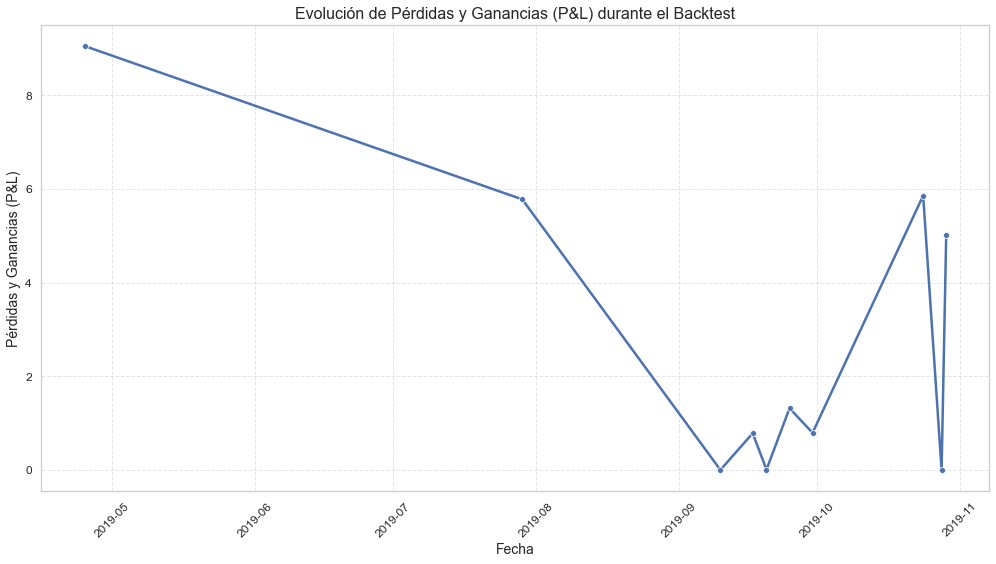

,date_time,instrument,client,price,mid,vol_MM,dv01,num_dealers,side,won,spread,date,time,periodOfDay,price_algo,spread_algo,won_algo,inventory_algo
1603,2019-10-24 11:12:53,A,B,110.726,110.7400,0.003,9.3811,10,1,0,0.0140,2019-10-24,11:12:53,morning,113.446738,-2.706738,0,0.0
1604,2019-10-24 11:54:23,K,B,127.345,127.3232,0.014,6.8256,10,-1,0,0.0218,2019-10-24,11:54:23,morning,123.311729,-4.011471,0,0.0
1606,2019-10-24 10:09:34,D,A,117.569,117.5963,0.500,16.7509,5,1,0,0.0273,2019-10-24,10:09:34,morning,129.144478,-11.548178,0,0.0
1607,2019-10-24 11:08:47,L,A,102.146,102.1389,0.500,4.9315,5,-1,0,0.0071,2019-10-24,11:08:47,morning,88.285204,-13.853696,1,0.0
1609,2019-10-24 14:20:34,G,B,109.203,109.1922,7.500,7.4952,5,1,0,-0.0108,2019-10-24,14:20:34,afternoon,142.708316,-33.516116,1,0.0
1623,2019-04-25 15:04:19,C,B,103.401,103.4006,0.032,9.6106,5,-1,1,0.0004,2019-04-25,15:04:19,afternoon,97.350961,-6.049639,1,0.0


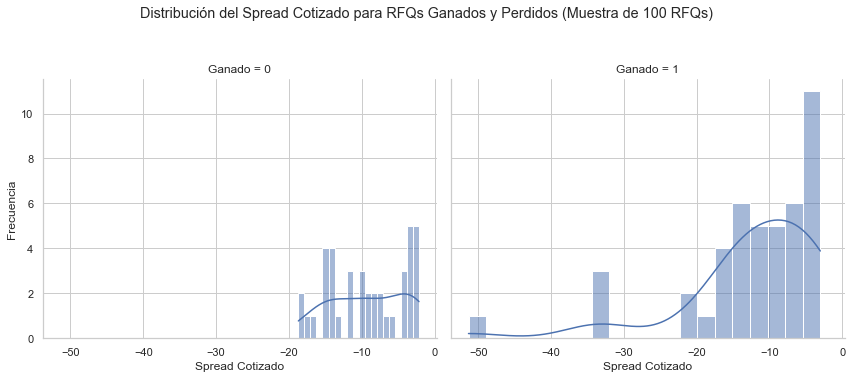

In [37]:
# Configuración de seaborn para mejorar las visualizaciones
sns.set(style="whitegrid")

# Visualizar los resultados del P&L
plt.figure(figsize=(14, 8))
sns.lineplot(data=pl_result_df, x='date', y='P&L', marker='o', linewidth=2.5, color='b')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Pérdidas y Ganancias (P&L)', fontsize=14)
plt.title('Evolución de Pérdidas y Ganancias (P&L) durante el Backtest', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

# Visualizar algunos resultados del RFQ
def visualize_rfqs(rfq_result_df, num_rfqs=10):
    """
    Visualiza los primeros RFQs ganados y perdidos durante el backtest.
    Args:
        rfq_result_df (DataFrame): DataFrame con los resultados del RFQ.
        num_rfqs (int): Número de RFQs a visualizar.
    """
    # Mostrar un resumen de los primeros RFQs ganados y perdidos
    won_rfqs = rfq_result_df[rfq_result_df['won_algo'] == 1].head(num_rfqs)
    lost_rfqs = rfq_result_df[rfq_result_df['won_algo'] == 0].head(num_rfqs)

    # Concatenar y visualizar
    rfqs_summary = pd.concat([won_rfqs, lost_rfqs], axis=0)
    rfqs_summary = rfqs_summary.sort_index()
    display(rfqs_summary)

# Visualizar los primeros 3 resultados del RFQ ganados y perdidos
visualize_rfqs(rfq_result_df, num_rfqs=3)

# Visualización adicional del spread y resultados de RFQ
g = sns.FacetGrid(rfq_result_df.head(100), col="won_algo", height=5, aspect=1.2)
g.map(sns.histplot, "spread_algo", kde=True, bins=20)
g.set_axis_labels("Spread Cotizado", "Frecuencia")
g.set_titles(col_template="Ganado = {col_name}")
plt.suptitle('Distribución del Spread Cotizado para RFQs Ganados y Perdidos (Muestra de 100 RFQs)', y=1.05)
plt.tight_layout()
plt.show()

### Interpretación de Resultados del Backtesting

#### Evolución de Pérdidas y Ganancias (P&L) durante el Backtest
El gráfico de P&L muestra una disminución inicial significativa en las ganancias, indicando operaciones negativas. Durante los meses de septiembre y noviembre el P&L alcanzó su punto más bajo, .

#### Distribución del Spread Cotizado para RFQs Ganados y Perdidos
El histograma del spread muestra cómo los niveles de spread afectan la probabilidad de ganar un RFQ. Los spreads bajos se concentran en los RFQs ganados, indicando precios más atractivos para los clientes. Los spreads amplios aparecen en los RFQs perdidos, lo cual reduce la probabilidad de aceptación. 


